<a href="https://colab.research.google.com/github/ashamlire51-debug/ds_shamli_akhare-/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# List contents of the mounted drive directory
print(os.listdir('/content/drive'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive'

In [ ]:
import os

base_path = "/content/drive/MyDrive/ds_shamli_akhare"

folders = [
    base_path,
    f"{base_path}/csv_files",
    f"{base_path}/outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created successfully")



Folder structure created successfully


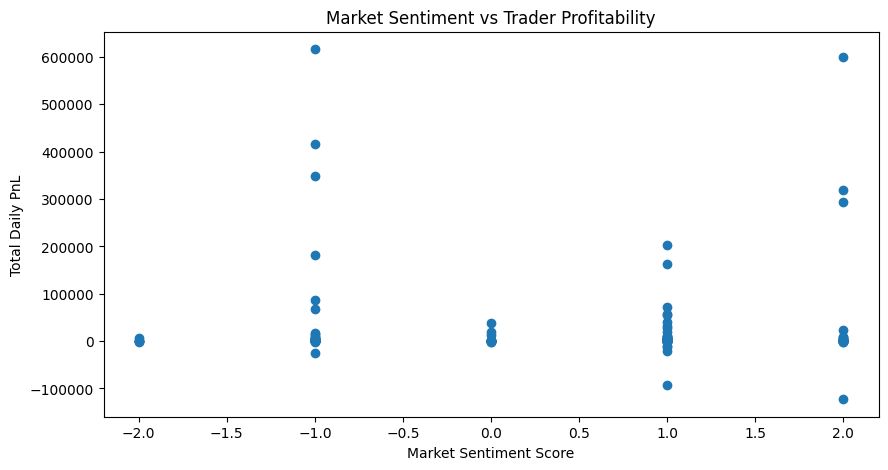

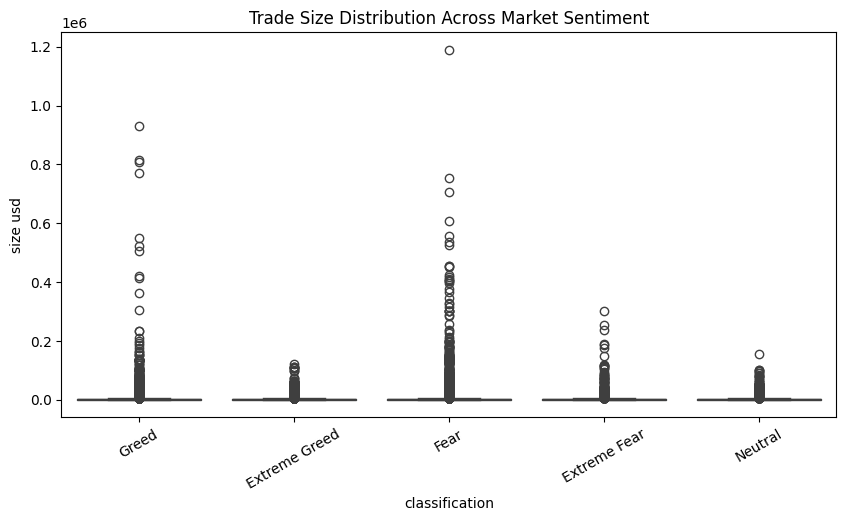

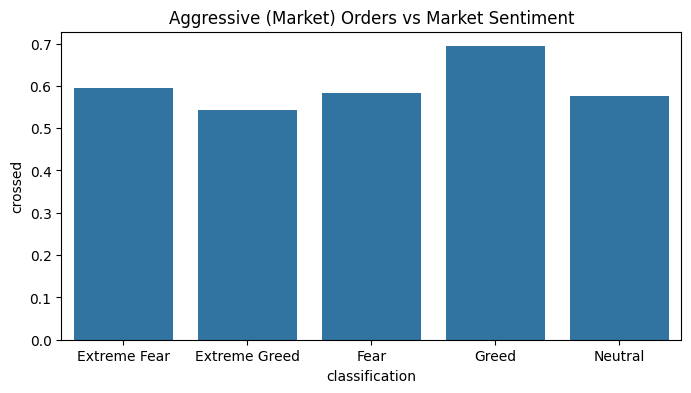

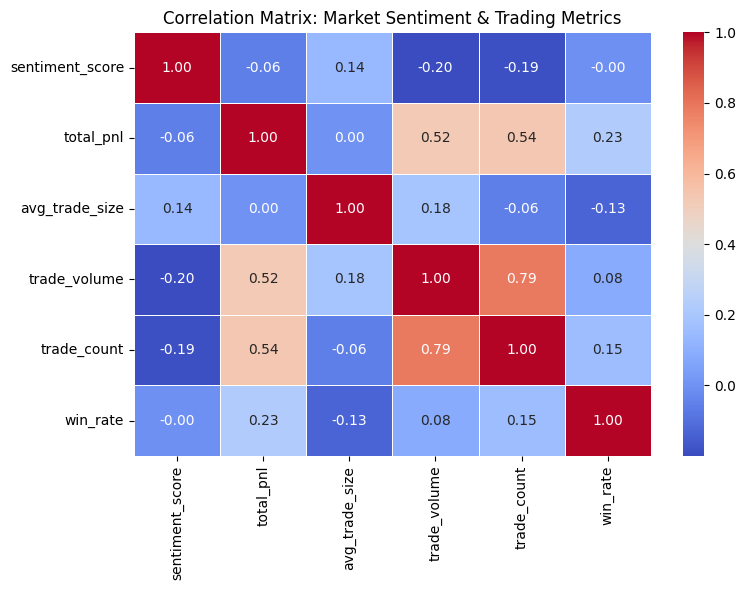

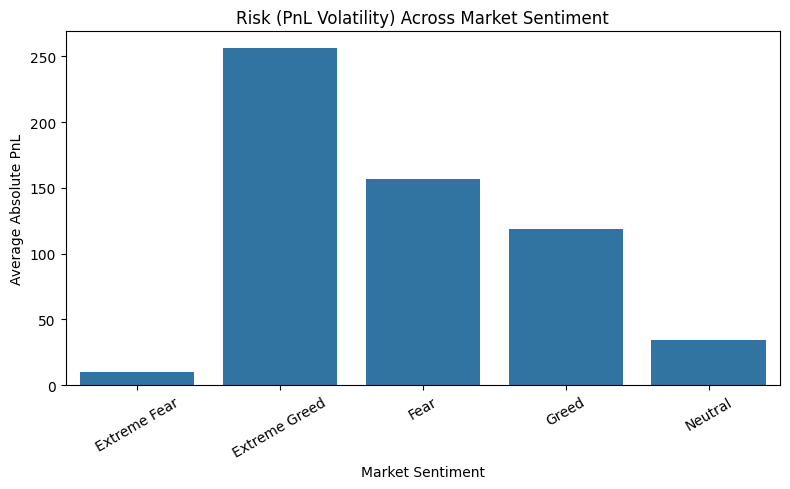

,classification,avg_pnl,median_pnl,win_rate,avg_trade_size
0,Extreme Fear,1.891632,0.00000,0.292777,4118.761840
1,Extreme Greed,205.816345,0.96048,0.553282,3242.085086
2,Fear,128.287950,0.00000,0.381787,5744.782685
3,Greed,53.988003,0.00000,0.435707,5051.878829
4,Neutral,27.088803,0.00000,0.494920,4332.202906


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("default")
# Base directory (MUST match assignment structure)
base_path = "/content/ds_shamli_akhare"

os.makedirs(f"{base_path}/csv_files", exist_ok=True)
os.makedirs(f"{base_path}/outputs", exist_ok=True)
# Dataset URLs (provided in assignment)
sentiment_url = "https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
trader_url = "https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"

# Load data
sentiment_df = pd.read_csv(sentiment_url)
trader_df = pd.read_csv(trader_url)

# Standardize column names (important for safety)
sentiment_df.columns = sentiment_df.columns.str.lower().str.strip()
trader_df.columns = trader_df.columns.str.lower().str.strip()

sentiment_df.head(), trader_df.head()
# Convert timestamps
trader_df['timestamp ist'] = pd.to_datetime(trader_df['timestamp ist'], errors='coerce')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# Keep relevant columns only
trader_df = trader_df[
    ['account', 'timestamp ist', 'closed pnl', 'size usd',
     'side', 'trade id', 'fee', 'crossed']
]

sentiment_df = sentiment_df[
    ['date', 'classification']
]
# Convert sentiment to numeric scale
sentiment_map = {
    'Extreme Fear': -2,
    'Fear': -1,
    'Neutral': 0,
    'Greed': 1,
    'Extreme Greed': 2
}

sentiment_df['sentiment_score'] = sentiment_df['classification'].map(sentiment_map)
sentiment_df['classification'].value_counts()
# Trade date extraction
trader_df['date'] = trader_df['timestamp ist'].dt.date
sentiment_df['date'] = sentiment_df['date'].dt.date

# Profitability flag
trader_df['is_profitable'] = trader_df['closed pnl'] > 0

# Relative leverage proxy (explained in report)
avg_size = trader_df['size usd'].mean()
trader_df['relative_leverage'] = trader_df['size usd'] / avg_size
merged_df = trader_df.merge(
    sentiment_df[['date', 'classification', 'sentiment_score']],
    on='date',
    how='left'
)

merged_df.head()
daily_trades = merged_df.groupby('date').agg(
    total_pnl=('closed pnl', 'sum'),
    avg_trade_size=('size usd', 'mean'),
    trade_volume=('size usd', 'sum'),
    trade_count=('trade id', 'count'),
    win_rate=('is_profitable', 'mean'),
    sentiment_score=('sentiment_score', 'mean')
).reset_index()

daily_trades.head()
daily_trades.to_csv(
    f"{base_path}/csv_files/daily_trades.csv",
    index=False
)
plt.figure(figsize=(10,5))
plt.scatter(daily_trades['sentiment_score'], daily_trades['total_pnl'])
plt.xlabel("Market Sentiment Score")
plt.ylabel("Total Daily PnL")
plt.title("Market Sentiment vs Trader Profitability")
plt.savefig(f"{base_path}/outputs/sentiment_vs_pnl.png")
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(
    x='classification',
    y='size usd',
    data=merged_df
)
plt.xticks(rotation=30)
plt.title("Trade Size Distribution Across Market Sentiment")
plt.savefig(f"{base_path}/outputs/trade_size_vs_sentiment.png")
plt.show()
crossed_analysis = merged_df.groupby('classification')['crossed'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(
    x='classification',
    y='crossed',
    data=crossed_analysis
)
plt.title("Aggressive (Market) Orders vs Market Sentiment")
plt.savefig(f"{base_path}/outputs/aggression_vs_sentiment.png")
plt.show()

# --- Correlation Matrix ---
corr_df = daily_trades[
    ['sentiment_score', 'total_pnl', 'avg_trade_size',
     'trade_volume', 'trade_count', 'win_rate']
]

corr_matrix = corr_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation Matrix: Market Sentiment & Trading Metrics')
plt.tight_layout()

plt.savefig(f"{base_path}/outputs/correlation_matrix.png")
plt.show()
# --- Risk Analysis ---
risk_df = merged_df.groupby('classification')['closed pnl'].apply(
    lambda x: x.abs().mean()
).reset_index(name='avg_abs_pnl')

plt.figure(figsize=(8,5))
sns.barplot(
    x='classification',
    y='avg_abs_pnl',
    data=risk_df
)
plt.title("Risk (PnL Volatility) Across Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Absolute PnL")
plt.xticks(rotation=30)
plt.tight_layout()

plt.savefig(f"{base_path}/outputs/risk_vs_sentiment.png")
plt.show()
sentiment_perf = merged_df.groupby('classification').agg(
    avg_pnl=('closed pnl', 'mean'),
    median_pnl=('closed pnl', 'median'),
    win_rate=('is_profitable', 'mean'),
    avg_trade_size=('size usd', 'mean')
).reset_index()

sentiment_perf.to_csv(
    f"{base_path}/csv_files/sentiment_performance.csv",
    index=False
)

sentiment_perf


In [ ]:
readme_text = """
# Trader Behavior vs Market Sentiment

## Objective
Analyze how trader profitability, risk, and execution behavior change
under Fear vs Greed market sentiment.

## Datasets
- Bitcoin Market Sentiment (Fear & Greed Index)
- Hyperliquid Historical Trader Data

## Key Analysis
- Profitability vs Sentiment
- Trade Size & Volume vs Sentiment
- Risk (PnL Volatility) vs Sentiment
- Execution Aggression vs Sentiment
- Correlation Matrix

## Tools Used
- Python
- Pandas
- Matplotlib
- Seaborn
- Google Colab

## Reproducibility
All analysis was performed in Google Colab.
"""

# Create README.md file
with open("/content/README.md", "w") as f:
    f.write(readme_text)

print("✅ README.md file created successfully")


✅ README.md file created successfully


In [ ]:
!ls /content
!mv /content/README.md /content/ds_shamli_akhare/


drive  ds_shamli_akhare  README.md  sample_data


In [ ]:
!zip -r ds_shamli_akhare.zip ds_shamli_akhare
from google.colab import files
files.download("ds_shamli_akhare.zip")


updating: ds_shamli_akhare/ (stored 0%)
updating: ds_shamli_akhare/ds_report (1).pdf (deflated 51%)
updating: ds_shamli_akhare/outputs/ (stored 0%)
updating: ds_shamli_akhare/outputs/correlation_matrix.png (deflated 9%)
updating: ds_shamli_akhare/outputs/trade_size_vs_sentiment.png (deflated 17%)
updating: ds_shamli_akhare/outputs/aggression_vs_sentiment.png (deflated 19%)
updating: ds_shamli_akhare/outputs/.ipynb_checkpoints/ (stored 0%)
updating: ds_shamli_akhare/outputs/sentiment_vs_pnl.png (deflated 20%)
updating: ds_shamli_akhare/outputs/risk_vs_sentiment.png (deflated 18%)
updating: ds_shamli_akhare/csv_files/ (stored 0%)
updating: ds_shamli_akhare/csv_files/daily_trades.csv (deflated 57%)
updating: ds_shamli_akhare/csv_files/sentiment_performance.csv (deflated 36%)
updating: ds_shamli_akhare/README.md (deflated 44%)
updating: ds_shamli_akhare/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>